In [ ]:
# Build the Retrieval QA Chain with proper citations
# Read Resource 1. <How to get your RAG application to return sources?> (https://python.langchain.com/docs/how_to/qa_sources/)


# 1. use LangSmith
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

In [2]:
# Configure environment to connect to LangSmith.
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"]="KI_multi-modal-RAG"

In [3]:
# 4. Components
# 4.1 Select chat model: Google Gemini

import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")


In [4]:
# 4.2 Select embedding model: HuggingFace
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

In [5]:
# 4.3 Select vector store: Chroma (install and upgrade langchain_chroma)
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

In [6]:
# RAG application: reconstruct the Q&A app with sources
# 1. index our documents:

from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Load PDF files from a folder
import os
folder_path = r"D:\4-IntoCode\16_LangChain\AgilProjekt_multiModel\Raw_Data\Apple"  # company folder, Use raw string
all_docs = []

for file in os.listdir(folder_path):
    if file.endswith(".pdf"):
        loader = PyPDFLoader(os.path.join(folder_path, file))
        pages = loader.load_and_split()
        all_docs.extend(pages)

# Split into chunks
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
docs = splitter.split_documents(all_docs)
print(f"Loaded {len(docs)} chunks from {len(all_docs)} pages across {len(os.listdir(folder_path))} PDF files.")
# Result: "Loaded 4419 chunks from 1347 pages across 22 PDF files.


Loaded 4419 chunks from 1347 pages across 22 PDF files.


In [7]:
# Index chunks
_ = vector_store.add_documents(documents=docs)

In [8]:
# 2. Next we build the RAG application:
from langchain import hub
from langchain_core.documents import Document
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

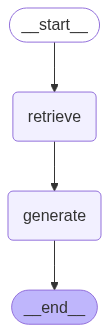

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
# Because we're tracking the retrieved context in our application's state, 
# it is accessible after invoking the application:

result = graph.invoke({"question": "What is Total net sales in 2020 in Apple Inc.?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='0179636d-5f4c-4a03-af7d-57a921dbdde3', metadata={'author': 'EDGAR® Online LLC, a subsidiary of OTC Markets Group', 'creationdate': '2024-11-01T06:05:37-04:00', 'creator': 'EDGAR Filing HTML Converter', 'keywords': '0000320193-24-000123; ; 10-K', 'moddate': '2024-11-01T06:06:09-04:00', 'page': 37, 'page_label': '38', 'producer': 'EDGRpdf Service w/ EO.Pdf 22.0.40.0', 'source': 'D:\\4-IntoCode\\16_LangChain\\AgilProjekt_multiModel\\Raw_Data\\Apple\\10-K-2024.pdf', 'subject': 'Form 10-K filed on 2024-11-01 for the period ending 2024-09-28', 'title': '0000320193-24-000123', 'total_pages': 121}, page_content='Total net sales $ 391,035 $ 383,285 $ 394,328 \n(1) Services net sales include amortization of the deferred value of services bundled in the sales price of certain products.\nTotal net sales include $7.7 billion of revenue recognized in 2024 that was included in deferred revenue as of September 30, 2023, $8.2 billion of revenuerecognized in 2023 that was included

In [ ]:
# Read Resource 2. <How to get a RAG application to add citations?> (https://python.langchain.com/docs/how_to/qa_citations/)

